<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 11**
- Francisco Martins, 99068
- Tunahan Güneş, 108108
- Sebastian Weidinger, 111612

In [1]:
from transformers import DistilBertTokenizer, DistilBertModel
from G11_code.data_collection import *
from G11_code.helper_functions import *
from G11_code.indexing import *
from G11_code.evaluation import *
from G11_code.clustering import *

c:\Users\marti\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
article_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "News Articles")
summary_path = os.path.join("..", "BBC News Summary", "BBC News Summary", "Summaries")
print("Article path:", article_path)
print("Summary path:", summary_path)
_article_file_paths_by_cat, _articles_by_cat, _summary_file_paths_by_cat, _summaries_by_cat, category_names= read_files(article_path, summary_path)

Article path: ..\BBC News Summary\BBC News Summary\News Articles
Summary path: ..\BBC News Summary\BBC News Summary\Summaries
Number of Categories: 5
Number of Articles in 'business' Category: 510
Number of Articles in 'entertainment' Category: 386
Number of Articles in 'politics' Category: 417
Number of Articles in 'sport' Category: 511
Number of Articles in 'tech' Category: 401


In [3]:
summary_sentence_indices_by_cat, faulty_summary_ids = get_summary_sentence_indices(_articles_by_cat, _summaries_by_cat)

number of found summaries: 2220
number of summaries: 2225
99.78%


In [4]:
articles_by_cat = remove_entries(_articles_by_cat, faulty_summary_ids)
articles = flatten(articles_by_cat)
article_file_paths_by_cat = remove_entries(_article_file_paths_by_cat, faulty_summary_ids)
article_file_paths = flatten(article_file_paths_by_cat)
summaries_by_cat = remove_entries(_summaries_by_cat, faulty_summary_ids)
summaries = flatten(summaries_by_cat)
summary_file_paths_by_cat = remove_entries(_summary_file_paths_by_cat, faulty_summary_ids)
summary_file_paths = flatten(summary_file_paths_by_cat)

In [5]:
path_to_articleID = lambda path: map_path_to_articleID(path, article_file_paths)

In [6]:
I = indexing(articles)

In [7]:
d=0
dissimilarity_matrix_tfidf = tf_idf_compute_dissimilarity_matrix(d, I)

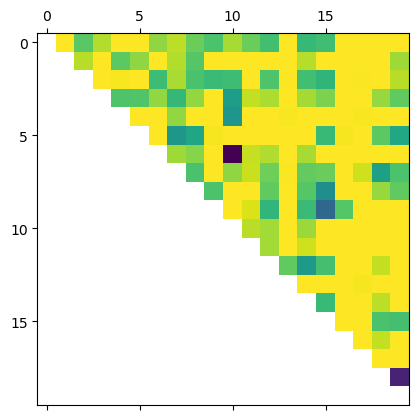

In [8]:
plt.matshow(dissimilarity_matrix_tfidf)

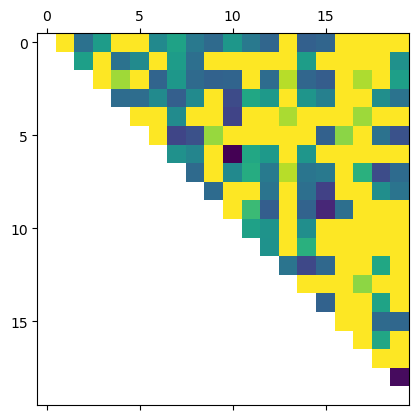

In [9]:
# If using another function to map the similarity matrix into a dissimilarity matrix such as d_ij = (1-s_ij^0.5)^2
plt.matshow((1-np.power(1 - dissimilarity_matrix_tfidf, 1/2))**2)

In [10]:
pretrained_weights = 'distilbert-base-uncased'
bert_tokenizer = DistilBertTokenizer.from_pretrained(pretrained_weights, do_lower_case=True)
bert_model = DistilBertModel.from_pretrained(pretrained_weights)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [11]:
dissimilarity_matrix_bert = bert_compute_dissimilarity_matrix(0, articles, bert_tokenizer, bert_model, device)

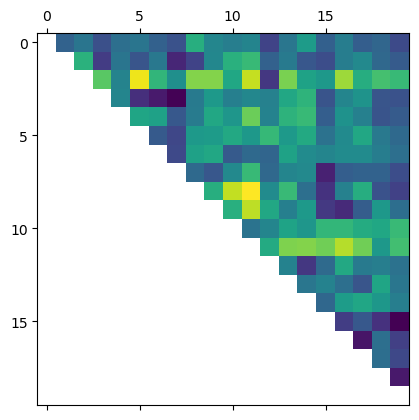

In [12]:
plt.matshow(dissimilarity_matrix_bert)

In [25]:
# print two closest sentences according to bert
for d in (0, 10, 600, 610, 900, 910):
    dissimilarity_matrix_bert = bert_compute_dissimilarity_matrix(d, articles, bert_tokenizer, bert_model, device)
    index_closest_bert = np.argmin(dissimilarity_matrix_bert)
    tokenized_article = nltk.sent_tokenize(articles[d])
    num_sent = len(tokenized_article)
    sent1 = index_closest_bert//num_sent
    sent2 = index_closest_bert%num_sent
    print(tokenized_article[sent1])
    print(tokenized_article[sent2])
    print(dissimilarity_matrix_bert[sent1, sent2])
    print('---')

TimeWarner is to restate its accounts as part of efforts to resolve an inquiry into AOL by US market regulators.
It will now book the sale of its stake in AOL Europe as a loss on the value of that stake.
0.028776705
---
The firm's revenue nearly tripled in the fourth quarter of 2004, exceeding $86m (Â£46m).
But on Thursday, it announced that a sharp turnaround had brought about an unexpected increase in profits.
0.04064268
---
Unusually, the runners-up in categories were also named with Clint Eastwood's Million Dollar Baby just missing out on the best film award.
The best director runner-up was Martin Scorsese for The Aviator.
0.0329172
---
Twelve films competing in the new world cinema documentary category focus on countries and people under siege.
The 16 films competing in the new world cinema dramatic category include works from Germany, South Korea, Angola, China, Denmark and Australia.
0.024558783
---
Prof Joni Lovenduski, who conducted the study with the help of Margaret Moran MP

In [26]:
# print two closest sentences according to tfidf
for d in (0, 10, 600, 610, 900, 910):
    dissimilarity_matrix_tfidf = tf_idf_compute_dissimilarity_matrix(d, I)
    index_closest_tfidf = np.argmin(dissimilarity_matrix_tfidf)
    tokenized_article = nltk.sent_tokenize(articles[d])
    num_sent = len(tokenized_article)
    sent1 = index_closest_tfidf//num_sent
    sent2 = index_closest_tfidf%num_sent
    print(tokenized_article[sent1])
    print(tokenized_article[sent2])
    print(dissimilarity_matrix_tfidf[sent1, sent2])
    print('---')

It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters.
Time Warner's fourth quarter profits were slightly better than analysts' expectations.
0.5712966777812147
---
Ask Jeeves has become the third leading online search firm this week to thank a revival in internet advertising for improving fortunes.
Late last year, marketing company Doubleclick, one of the leading providers of online advertising, warned that some or all of its business would have to be put up for sale.
0.7983408935807431
---
The awards will be handed out on 13 January at a ceremony in Las Vegas.
A career achievement award will be handed to veteran actor and comic Jerry Lewis at the ceremony next year.
0.765904440541825
---
Twelve films competing in the new world cinema documentary category focus on countries and people under siege.
The 16 films competing in the new world cinema dramatic category include works from Germany, South Korea, Angola, China, Denmark and Austr

<H2>Main facilities</H2>

<h3>Part I: clustering</h3>

*A) Clustering*

In [15]:
#code, statistics and/or charts here

*B) Summarization*

In [16]:
#code, statistics and/or charts here

*C) Keyword extraction*

In [17]:
#code, statistics and/or charts here

*D) Evaluation*

In [18]:
#code, statistics and/or charts here

<h3>Part II: classification</h3>

*A) Feature extraction*

In [19]:
#code and statistics here

*B) Classification*

In [20]:
#code here

*C) Ranking extension*

In [21]:
#code here

*D) Evaluation*

In [22]:
#code, statistics and/or charts here

<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

In [23]:
#code, statistics and/or charts here

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

In [24]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>